In [ ]:
class myNeuralNetwork(object):
    def __init__(self, n_in=2, n_layer1=5, n_layer2=5, n_out=1, learning_rate=0.01):
        """__init__
        Class constructor: Initialize the parameters of the network including
        the learning rate, layer sizes, and each of the parameters
        of the model (weights, placeholders for activations, inputs,
        deltas for gradients, and weight gradients). This method
        should also initialize the weights of your model randomly
            Input:
                n_in:          number of inputs
                n_layer1:      number of nodes in layer 1
                n_layer2:      number of nodes in layer 2
                n_out:         number of output nodes
                learning_rate: learning rate for gradient descent
            Output:
                none
        """
        self.n_in = n_in
        self.n_layer1 = n_layer1
        self.n_layer2 = n_layer2
        self.n_out = n_out
        self.learning_rate = learning_rate
        # initialize weights
        self.W1 = np.random.randn(n_layer1, n_in)
        self.W2 = np.random.randn(n_layer2, n_layer1)
        self.W3 = np.random.randn(n_out, n_layer2)

    def forward_propagation(self, x):
        """forward_propagation
        Takes a vector of your input data (one sample) and feeds
        it forward through the neural network, calculating activations and
        layer node values along the way.
            Input:
                x: a vector of data representing 1 sample [n_in x 1]
            Output:
                y_hat: a vector (or scaler of predictions) [n_out x 1]
                (typically n_out will be 1 for binary classification)
        """

        # input layer -> hidden layer 1
        self.a1 = np.dot(self.W1, x.T)
        self.z1 = self.sigmoid(self.a1)

        # hidden layer 1 -> hidden layer 2
        self.a2 = self.W2 @ self.z1
        self.z2 = self.sigmoid(self.a2)

        # hidden layer 2 -> output layer
        self.a3 = self.W3 @ self.z2
        z3 = self.sigmoid(self.a3)
        return z3

    def compute_loss(self, y_hat, y):
        """compute_loss
        Computes the current loss/cost function of the neural network
        based on the weights and the data input into this function.
        To do so, it runs the X data through the network to generate
        predictions, then compares it to the target variable y using
        the cost/loss function
            Input:
                y_hat: The estimation based on the forward propagation
                y: Target variable
            Output:
                loss: a scalar measure of loss/cost
        """
        # another way to compute the loss but takes forever
        # mean squared error loss function
        # y_hat = self.forward_propagation(X)
        # return np.mean(0.5 * (y - y_hat)**2)
        return 0.5 * (y_hat - y) ** 2

    def backpropagate(self, x, y):
        """backpropagate
        Backpropagate the error from one sample determining the gradients
        with respect to each of the weights in the network. The steps for
        this algorithm are:
            1. Run a forward pass of the model to get the activations
               Corresponding to x and get the loss functionof the model
               predictions compared to the target variable y
            2. Compute the deltas (see lecture notes) and values of the
               gradient with respect to each weight in each layer moving
               backwards through the network

            Input:
                x: A vector of 1 samples of data [n_in x 1]
                y: Target variable [scalar]
            Output:
                loss: a scalar measure of th loss/cost associated with x,y
                      and the current model weights
        """
        # using gradient descent to update the weights
        y_hat = self.forward_propagation(x)
        # output layer -> hidden layer 2
        delta3 = -(y - y_hat) * self.sigmoid_derivative(self.a3)
        dW3 = delta3[np.newaxis].T @ self.z2[np.newaxis]
        # hidden layer 2 -> hidden layer 1
        delta2 = np.dot(self.W3.T, delta3) * self.sigmoid_derivative(self.a2)
        dW2 = delta2[np.newaxis].T @ self.z1[np.newaxis]
        # hidden layer 1 -> input layer
        delta1 = np.dot(self.W2.T, delta2) * self.sigmoid_derivative(self.a1)
        dW1 = delta1[np.newaxis].T @ x[np.newaxis]

        # Update weights
        self.W3 -= self.learning_rate * dW3
        self.W2 -= self.learning_rate * dW2
        self.W1 -= self.learning_rate * dW1
        # Calculate loss
        loss = self.compute_loss(y_hat, y)
        return loss

    def stochastic_gradient_descent_step(self, X, y):
        """stochastic_gradient_descent_step - performs a single step of
        stochastic gradient descent on the training data
        by randomly shuffling the training data and testing each

        Input: X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
        Output: randomly shuffle the training data
        """
        # another way to update the weights
        # randomly shuffle the training data
        # idx = np.random.permutation(X.shape[0])
        # for i in idx:
        #     X_i  = X[i].reshape(-1,1)
        #     self.backpropagate(X_i,y[i])
        idx = random.choices(range(0, X.shape[0]), k=X.shape[0])
        return X[idx], y[idx]

    def fit(self, X, y, X_val, y_val, max_epochs=500, learning_rate=0.01, get_validation_loss=False):
        """fit
        Input:
            X: A matrix of N samples of data [N x n_in]
            y: Target variable [N x 1]
        Output:
            training_loss:   Vector of training loss values at the end of each epoch
            validation_loss: Vector of validation loss values at the end of each epoch
                             [optional output if get_validation_loss==True]
        """
        self.cost_function = []
        self.weights = []
        training_loss = []
        validation_loss = []

        for epoch in range(max_epochs):
            X_rand, y_rand = self.stochastic_gradient_descent_step(
                X, y)
            for i, j in zip(X_rand, y_rand):
                t_loss = self.backpropagate(i, j)
                training_loss.append(t_loss)
            self.cost_function.append(sum(training_loss) / len(training_loss))
            self.weights.append([self.W1, self.W2, self.W3])
            value_min = min(self.cost_function)
            index_min = self.cost_function.index(value_min)
            self.W1 = self.weights[index_min][0]
            self.W2 = self.weights[index_min][1]
            self.W3 = self.weights[index_min][2]
            if get_validation_loss:
                y_hat_val = self.predict_proba(X_val)
                v_loss = self.compute_loss(y_hat_val, y_val)
                validation_loss.append(np.mean(v_loss))
                return training_loss, validation_loss
            else:
                return training_loss

    def predict_proba(self, X):
        """predict_proba
        Compute the output of the neural network for each sample in X, with the last layer's
        sigmoid activation providing an estimate of the target output between 0 and 1
            Input:
                X: A matrix of N samples of data [N x n_in]
            Output:
                y_hat: A vector of class predictions between 0 and 1 [N x 1]
        """
        return self.forward_propagation(X)

    def predict(self, X, decision_thresh=0.5):
        """predict
        Compute the output of the neural network prediction for
        each sample in X, with the last layer's sigmoid activation
        providing an estimate of the target output between 0 and 1,
        then thresholding that prediction based on decision_thresh
        to produce a binary class prediction
            Input:
                X: A matrix of N samples of data [N x n_in]
                decision_threshold: threshold for the class confidence score
                                    of predict_proba for binarizing the output
            Output:
                y_hat: A vector of class predictions of either 0 or 1 [N x 1]
        """
        return (self.forward_propagation(X) > decision_thresh).astype(int)

    def sigmoid(self, X):
        """sigmoid
        Compute the sigmoid function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid function
        """
        # Our activation function: f(x) = 1 / (1 + e^(-x))
        return 1 / (1 + np.exp(-X))

    def sigmoid_derivative(self, X):
        """sigmoid_derivative
        Compute the sigmoid derivative function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid derivative function
        """
        # sigmoid derivative: f'(x) = f(x) * (1 - f(x))
        return self.sigmoid(X) * (1 - self.sigmoid(X))


In [ ]:
class myNeuralNetwork():

    def __init__(self, n_in=2, n_layer1=5, n_layer2=5, n_out=1, learning_rate=0.01):
        '''__init__
        Class constructor: Initialize the parameters of the network including
        the learning rate, layer sizes, and each of the parameters
        of the model (weights, placeholders for activations, inputs, 
        deltas for gradients, and weight gradients). This method
        should also initialize the weights of your model randomly
            Input:
                n_in:          number of inputs
                n_layer1:      number of nodes in layer 1
                n_layer2:      number of nodes in layer 2
                n_out:         number of output nodes
                learning_rate: learning rate for gradient descent
            Output:
                none
        '''
        self.cost_function = []
        self.validation_loss = []
        self.weights = []
        self.lr = learning_rate
        # Initiate weights
        self.w_1 = self.generate_wt(n_layer1, n_in)
        self.w_2 = self.generate_wt(n_layer2, n_layer1)
        self.w_3 = self.generate_wt(n_out, n_layer2)
        pass

    def forward_propagation(self, x):
        '''forward_propagation
        Takes a vector of your input data (one sample) and feeds
        it forward through the neural network, calculating activations and
        layer node values along the way.
            Input:
                x: a vector of data representing 1 sample [n_in x 1]
            Output:
                y_hat: a vector (or scaler of predictions) [n_out x 1]
                (typically n_out will be 1 for binary classification)
        '''
        # Input - Layer 1
        self.a_1 = np.dot(self.w_1, x.T)
        self.z_1 = self.sigmoid(self.a_1)

        # Layer 1 - Layer 2
        self.a_2 = self.w_2 @ self.z_1
        self.z_2 = self.sigmoid(self.a_1)

        # Output layer
        self.a_3 = self.w_3 @ self.z_2
        y_hat = self.sigmoid(self.a_3)
        return y_hat

    def compute_loss(self, y_hat, y):
        '''compute_loss
        Computes the current loss/cost function of the neural network
        based on the weights and the data input into this function.
        To do so, it runs the X data through the network to generate
        predictions, then compares it to the target variable y using
        the cost/loss function
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                loss: a scalar measure of loss/cost
        '''
        return 0.5 * (y_hat - y) ** 2

    def backpropagate(self, x, y):
        '''backpropagate
        Backpropagate the error from one sample determining the gradients
        with respect to each of the weights in the network. The steps for
        this algorithm are:
            1. Run a forward pass of the model to get the activations 
               Corresponding to x and get the loss functionof the model 
               predictions compared to the target variable y
            2. Compute the deltas (see lecture notes) and values of the
               gradient with respect to each weight in each layer moving
               backwards through the network

            Input:
                x: A vector of 1 samples of data [n_in x 1]
                y: Target variable [scalar]
            Output:
                loss: a scalar measure of th loss/cost associated with x,y
                      and the current model weights
        '''
        y_hat = self.forward_propagation(x)

        # Compute deltas
        delta_3 = ((y_hat-y) * self.sigmoid_derivative(self.a_3))
        delta_2 = np.multiply((self.w_3.T @ delta_3),
                              self.sigmoid_derivative(self.a_2))
        delta_1 = np.multiply((self.w_2.T @ delta_2),
                              self.sigmoid_derivative(self.a_1))

        # Compute gradients
        grad_w_1 = delta_1[np.newaxis].T @ x[np.newaxis]
        grad_w_2 = delta_2[np.newaxis].T @ self.z_1[np.newaxis]
        grad_w_3 = delta_3[np.newaxis].T @ self.z_2[np.newaxis]

        # Gradient descent step: NEW WEIGHTZZZ
        self.w_1 = self.w_1 - (self.lr * grad_w_1)
        self.w_2 = self.w_2 - (self.lr * grad_w_2)
        self.w_3 = self.w_3 - (self.lr * grad_w_3)

        return self.compute_loss(y_hat, y)

    def fit(self, X, y, X_val, y_val, max_epochs=500, get_validation_loss=True):
        '''fit
            Input:
                X: A matrix of N samples of data [N x n_in]
                y: Target variable [N x 1]
            Output:
                training_loss:   Vector of training loss values at the end of each epoch
                validation_loss: Vector of validation loss values at the end of each epoch
                                 [optional output if get_validation_loss==True]
        '''
        for epoch in range(max_epochs):
            X_rand, y_rand = self.randomized(X, y)
            epoch_loss = []

            # Iterations on each epoch
            for i, j in zip(X_rand, y_rand):
                loss = self.backpropagate(i, j)
                epoch_loss.append(loss)
                # did a forward pass an calculated gradients
                # Also computed new weights
                # And, saved the new cost in the list
            # 1 EPOCH IS DONE!
            self.cost_function.append(sum(epoch_loss)/len(epoch_loss))
            self.weights.append([self.w_1, self.w_2, self.w_3])
            if get_validation_loss == True:

                # print('Mean Loss at epoch {} = {}'.format(epoch, sum(epoch_loss)/len(epoch_loss)))

                y_hat_val = self.predict_proba(X_val)
                cost_val = self.compute_loss(y_hat_val, y_val)
                self.validation_loss.append(np.mean(cost_val))
        min_value = min(self.cost_function)
        min_index = self.cost_function.index(min_value)
        self.w_1 = self.weights[min_index][0]
        self.w_2 = self.weights[min_index][1]
        self.w_3 = self.weights[min_index][2]

    def predict_proba(self, X):
        '''predict_proba
        Compute the output of the neural network for each sample in X, with the last layer's
        sigmoid activation providing an estimate of the target output between 0 and 1
            Input:
                X: A matrix of N samples of data [N x n_in]
            Output:
                y_hat: A vector of class predictions between 0 and 1 [N x 1]
        '''
        return self.forward_propagation(X)

    def predict(self, X, decision_thresh=0.5):
        '''predict
        Compute the output of the neural network prediction for 
        each sample in X, with the last layer's sigmoid activation 
        providing an estimate of the target output between 0 and 1, 
        then thresholding that prediction based on decision_thresh
        to produce a binary class prediction
            Input:
                X: A matrix of N samples of data [N x n_in]
                decision_threshold: threshold for the class confidence score
                                    of predict_proba for binarizing the output
            Output:
                y_hat: A vector of class predictions of either 0 or 1 [N x 1]
        '''

        return self.predict_proba(X) >= decision_thresh

    def sigmoid(self, X):
        '''sigmoid
        Compute the sigmoid function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid function
        '''
        return 1/(1+np.exp(-X))

    def sigmoid_derivative(self, X):
        '''sigmoid_derivative
        Compute the sigmoid derivative function for each value in matrix X
            Input:
                X: A matrix of any size [m x n]
            Output:
                X_sigmoid: A matrix [m x n] where each entry corresponds to the
                           entry of X after applying the sigmoid derivative function
        '''
        sig = self.sigmoid(X)
        return sig * (1 - sig)

    def generate_wt(self, a, b):
        ''' Initialize weights of any size'''
        l = []
        for i in range(a * b):
            l.append(np.random.randn())
        return (np.array(l).reshape(a, b))

    def randomized(self, X, y):
        idx = random.choices(range(0, X.shape[0]), k=X.shape[0])
        return X[idx], y[idx]

    def fix_shape(self, array):
        return array[np.newaxis].T


In [ ]:
# set layer and node based on the previous results
# lr = learning_rates[np.argmax(lr_accuracy)]
# reg = regularization[np.argmax(reg_accuracy)]
# batch = batch_sizes[np.argmax(batch_accuracy)]
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score

layer = (10, 10)
mlp_manual = mlp_classifer(
    hidden_layer_sizes=layer, learning_rate_init=lr, alpha=reg, batch_size=batch
)
print(
    "The manual best model has an accuracy of {} when we test in testing data".format(
        mlp_manual.score(X_test, y_test)
    )
)
# Define the hyperparameters
params = {
    "hidden_layer_sizes": (2, 10),
    "learning_rate_init": lr,
    "alpha": reg,
    "solver": "sgd",
    "tol": 1e-5,
    "early_stopping": False,
    "activation": "relu",
    "n_iter_no_change": 1000,
    "batch_size": batch,
    "max_iter": 500,
}

# Train the model on all the training and validation data
model_greedy = MLPClassifier(**params)
model_greedy.fit(X_train_plus_val, y_train_plus_val)

# Evaluate the model on the test set
y_pred = model_greedy.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.3f}".format(test_acc))

# Compute the ROC curve and AUC score
y_prob = model_greedy.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC curve (area = {:.3f})".format(auc))
ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random guessing")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver operating characteristic (ROC) curve")
ax.legend(loc="lower right")
plt.show()


In [ ]:
# set up the grid search parameters
param_grid = {
    "learning_rate": [0.1, 0.01, 0.001],
    "max_epochs": [500, 1000, 2000, 3000],
}
for learning_rate in param_grid["learning_rate"]:
    for max_epochs in param_grid["max_epochs"]:
        nn = myNeuralNetwork(learning_rate=learning_rate)
        nn.fit(
            X_train_moon, y_train_moon, X_val_moon, y_val_moon, max_epochs=max_epochs
        )
        training_loss = nn.cost_function
        plt.plot(
            training_loss,
            label="Learning rate: "
            + str(learning_rate)
            + ", Epochs: "
            + str(max_epochs),
        )
        print(
            "Learning rate: " + str(learning_rate) +
            ", Epochs: " + str(max_epochs),
            "Training loss: ",
            training_loss[-1],
        )
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Learning curves for different hyperparameters")
plt.show()


In [4]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# Create training, validation, and test datasets
N_train = 500
N_test = 100
X, y = make_moons(N_train + N_test, noise=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=N_test, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)


In [6]:
idx = np.random.permutation(X_train.shape[0])
for i in idx:
    print(X_train[i], y_train[i])


[0.0497155  1.18000638] 0
[ 0.28286373 -0.49823475] 1
[-0.99717956  0.36625365] 0
[1.43490257 0.35214387] 1
[-1.17294886  0.85348354] 0
[-0.8697229   0.33448305] 0
[0.76646791 1.15635944] 0
[-1.04768639  0.83954361] 0
[1.71129945 0.04543038] 1
[-0.599014    0.62319734] 0
[-0.98701414  0.41535375] 0
[-0.0560974   0.08494591] 1
[0.03271477 0.85611776] 0
[-0.21763375  0.85907536] 0
[1.12665947 0.44571536] 0
[1.03097555 0.37777989] 0
[ 1.71753261 -0.17130622] 1
[1.04488858 0.12152307] 0
[-0.66673136  0.67101844] 0
[ 0.58413807 -0.52083984] 1
[-0.08373787  0.9689945 ] 0
[-0.46181582  1.0341428 ] 0
[0.49434053 0.8994933 ] 0
[ 1.5950776  -0.66355318] 1
[0.07540208 0.30977001] 1
[1.50700603 0.28939968] 1
[ 1.73874125 -0.05885145] 1
[ 1.74614445 -0.23696991] 1
[0.4485357  0.67418395] 0
[ 1.49554928 -0.14240095] 1
[-0.01465594 -0.15638416] 1
[ 0.47110739 -0.39465297] 1
[0.38032726 0.11657802] 1
[-0.95226787  0.45558919] 0
[0.1373189  0.22693396] 1
[ 0.70407854 -0.33479636] 1
[-0.36880698  1.2095

In [24]:
myNN = myNeuralNetwork(n_in=2, n_layer1=5, n_layer2=5,
                       n_out=1, learning_rate=0.01)

# Train the model and collect the cost values for each epoch
training_loss, validation_loss = myNN.fit(
    X_train, y_train, max_epochs=1000, learning_rate=0.01, get_validation_loss=True)


ValueError: shapes (1,) and (5,) not aligned: 1 (dim 0) != 5 (dim 0)

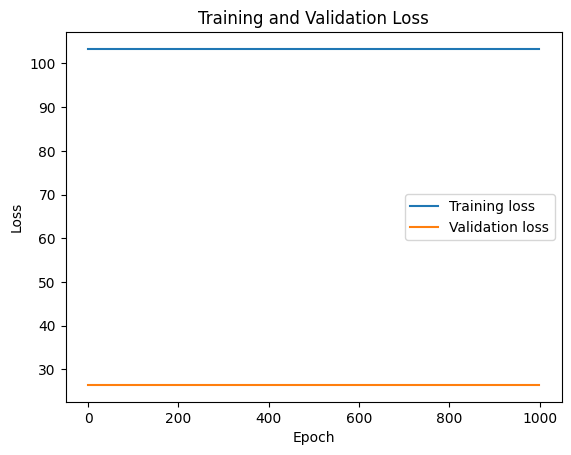

In [12]:
import matplotlib.pyplot as plt
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [8]:
X = X_train
X.shape[0]


400

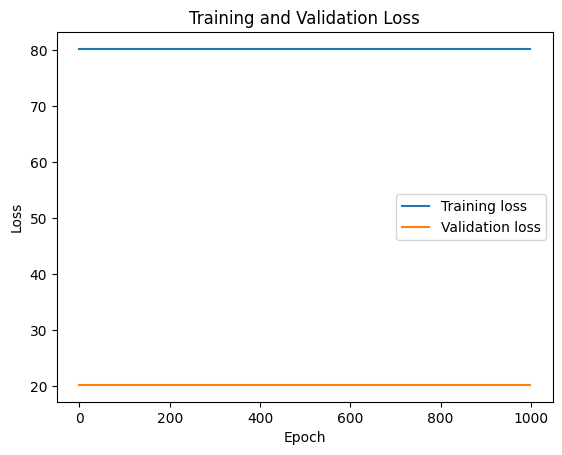

In [29]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
# Train the model on the combined training and validation sets with the best hyperparameters
clf = myNeuralNetwork(n_in=2, n_layer1=5, n_layer2=5,
                      n_out=1, learning_rate=0.1)
clf.fit(np.concatenate([X_train, X_val]),
        np.concatenate([y_train, y_val]), max_epochs=2000)

# Create a 2x1 subplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Plot the decision boundary on the training data
scatter0 = axs[0].scatter(X_train[:, 0], X_train[:, 1],
                          c=y_train, cmap=plt.cm.Spectral)
axs[0].set_title('Decision boundary for training data')
xx, yy = np.meshgrid(np.linspace(-2, 3, 100), np.linspace(-2, 2, 100))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contour0 = axs[0].contourf(
    xx, yy, Z, levels=[0, 0.5, 1], alpha=0.5, cmap=plt.cm.Spectral)
axs[0].contour(xx, yy, Z, levels=[0.5], colors='k')
axs[0].set_xticks([])
axs[0].set_yticks([])

# Plot the decision boundary on the validation data
scatter1 = axs[1].scatter(X_val[:, 0], X_val[:, 1],
                          c=y_val, cmap=plt.cm.Spectral)
axs[1].set_title('Decision boundary for validation data')
contour1 = axs[1].contourf(
    xx, yy, Z, levels=[0, 0.5, 1], alpha=0.5, cmap=plt.cm.Spectral)
axs[1].contour(xx, yy, Z, levels=[0.5], colors='k')
axs[1].set_xticks([])
axs[1].set_yticks([])

# Create legend
handles = [scatter0.legend_elements()[0][0], scatter0.legend_elements()[0][1]]
labels = ['Class 1', 'Class 0']
fig.legend(handles, labels, loc='center')

plt.show()


In [92]:
nn_architecture = [
    {"input_dim": 2, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 6, "activation": "relu"},
    {"input_dim": 6, "output_dim": 6, "activation": "relu"},
    {"input_dim": 6, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 1, "activation": "sigmoid"},
]


def init_layers(nn_architecture, seed=99):
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {}

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]

        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1

    return params_values


def sigmoid(Z):
    return 1/(1+np.exp(-Z))


def relu(Z):
    return np.maximum(0, Z)


def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)


def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ


def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.dot(W_curr, A_prev) + b_curr

    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')

    return activation_func(Z_curr), Z_curr


def full_forward_propagation(X, params_values, nn_architecture):
    memory = {}
    A_curr = X

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr

        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(
            A_prev, W_curr, b_curr, activ_function_curr)

        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr

    return A_curr, memory


def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) +
                     np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)


def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()


def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    m = A_prev.shape[1]

    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')

    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr


def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)

    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))

    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]

        dA_curr = dA_prev

        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]

        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)

        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr

    return grads_values


def update(params_values, grads_values, nn_architecture, learning_rate):
    for layer_idx, layer in enumerate(nn_architecture):
        params_values["W" + str(layer_idx)] -= learning_rate * \
            grads_values["dW" + str(layer_idx)]
        params_values["b" + str(layer_idx)] -= learning_rate * \
            grads_values["db" + str(layer_idx)]

    return params_values


def train(X, Y, nn_architecture, epochs, learning_rate):
    params_values = init_layers(nn_architecture, 2)
    cost_history = []
    accuracy_history = []

    for i in range(epochs):
        Y_hat, cashe = full_forward_propagation(
            X, params_values, nn_architecture)
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)

        grads_values = full_backward_propagation(
            Y_hat, Y, cashe, params_values, nn_architecture)
        params_values = update(params_values, grads_values,
                               nn_architecture, learning_rate)

    return params_values, cost_history, accuracy_history


# test the model
params_values, cost_history, accuracy_history = train(
    X_train, y_train, nn_architecture, 1000, 0.01)


<>:45: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:47: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:89: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:45: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:47: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:89: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_2184/279329428.py:45: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if activation is "relu":
/tmp/ipykernel_2184/279329428.py:47: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif activation is "sigmoid":
/tmp/ipykernel_2184/279329428.py:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if activation is "relu":
/tmp/ipykernel_2184/279329428.py:89: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif activation is "sigmoid":
/tmp/ipykernel_218

ValueError: shapes (4,2) and (400,2) not aligned: 2 (dim 1) != 400 (dim 0)